In [1]:
using LinearAlgebra
using ControlSystems
using Plots
using ControlSystemIdentification
using Random
using Statistics
using CUDA
using Flux

include("KugaPack.jl")
include("sysid.jl")
include("blockpack.jl")
include("analysis.jl")

CUDA.allowscalar(true)

In [2]:
#numerical conditions are set up
dt =5e-3;
maxT = 5;
ns = round(Int,maxT/dt)+1;
t = 0:dt:maxT;

ny = 2
ns

1001

In [3]:
#problem conditions are set up
x0 = [0; 0; 0; 0;];

U = [1; zeros(ns-1)];

In [4]:
data_size = 5000
m_max = 10
ξ_max = 0.5
k_max = 1000

Respostas = Vector{Vector}(undef,data_size)

Param = [ParamGen(m_max,ξ_max,k_max) for i=1:data_size]

for i=1:data_size
    sysP,sysD = F2DOF(dt,Param[i]);
    Y,_,_= lsim(sysD,U',t,x0=x0); #time response   
    Respostas[i] = vec(reshape(Y,(ny*ns,1)));
end

#sub-amortecidos apenas -> em torno de um comportamento mais conhecido
#troca a função de ativação 

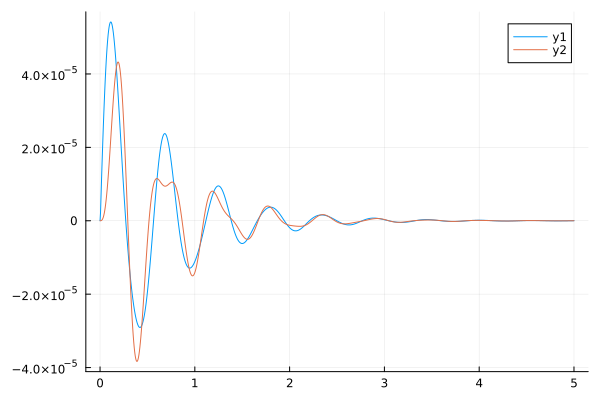

In [110]:
plot(t,reshape(Respostas[rand(1:data_size)],(ny,ns))')

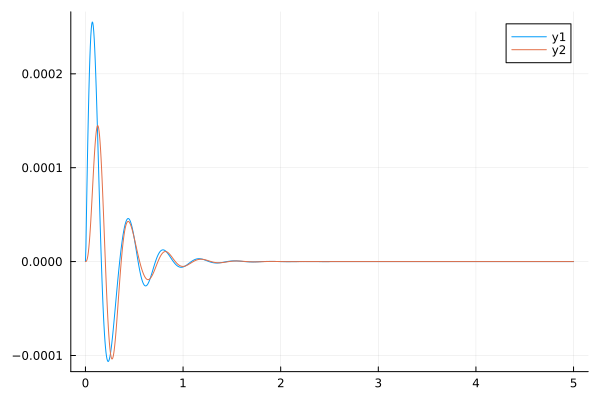

In [5]:
#using the given parameters, the system (discrete space state) is created 
ParamOr = [0.77 0.59 2.1 1.2 9 200 200 200];
sysP,sysD = F2DOF(dt,ParamOr);

Y,_,_= lsim(sysD,U',t,x0=x0); #time response
magD,phaseD,w = bode(sysD); #frequency response

plot(t,Y')

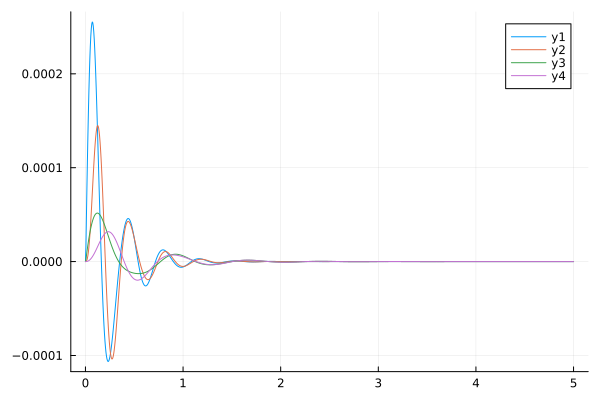

In [148]:
Data = zip(Respostas |> gpu ,Param |> gpu)
V = [ns*ny, 1000, 8]
model = Simple(V,tanh)

model = TrainModel(model,Data)

ParamEst = model(reshape(Y,(ns*ny,1)) |> gpu)
sysPest,sysDest = F2DOF(dt,[Float64(i) for i in ParamEst]);
Yest,_,_= lsim(sysDest,U',t,x0=x0); 

plot(t,[Y' Yest'])

In [136]:
Entradas = ns*ny;
Saidas = 8;

inicio = 1
maxIt = 30

passo = 1

iter = (inicio:maxIt).*passo


InfoGen2 = Matrix{Float64}(undef, maxIt,maxIt)

ModelAval = reshape(Y,(ns*ny,1)) |> gpu

for i in iter
    for j in iter
        print(string(i)*"-"*string(j)*"\r")
        V = Int.([Entradas; i*ones(j); Saidas])
        model = TrainModel(Simple(V,relu),Data)
        ParamEst = model(ModelAval)
        sysPest,sysDest = F2DOF(dt,[Float64(i) for i in ParamEst]);
        Yest,_,_= lsim(sysDest,U',t,x0=x0); 
        l = Int64(round(i/passo))
        m = Int64(round(j/passo))
        InfoGen2[l,m] = norm(Y- Yest)/norm(Y)
    end
end

minimum(InfoGen2) #0.7751273082239163
writedlm( "infogen_restrito2.csv",  InfoGen2, ';')

In [ ]:
png(
    plot(
    heatmap(InfoGen2), 
    ylabel = "Largura da Rede", 
    xlabel = "Profundidade da Rede",
    title  = "Erro na Identificação - Rede Identificadora",
),"rede_identificadora_subamortecidosapenas_erro");

In [7]:
Data = zip(Respostas |> gpu ,Param |> gpu)
V = Int.([ns*ny; 11*ones(22); 8])

model = TrainModel(Simple(V,relu),Data)

ParamEst = model(reshape(Y,(ns*ny,1)) |> gpu)
sysPest,sysDest = F2DOF(dt,[Float64(i) for i in ParamEst]);
Yest,_,_= lsim(sysDest,U',t,x0=x0); 

png(
    plot(
    t,
    [Y' Yest'], 
    labels=["Massa 1" "Massa 2" "Massa 1 - estimado" "Massa 2 - estimado"],
    ylabel = "Largura da Rede", 
    xlabel = "Profundidade da Rede",
    title  = "Erro na Identificação - Rede Identificadora",
),"resposta_rede_identificacao2");

In [11]:
norm(Y- Yest)/norm(Y)

0.8867689928521574